In [299]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

STOCK = "TSLA"

In [300]:
import warnings
warnings.filterwarnings("ignore")

In [301]:
context = mx.cpu(); model_ctx = mx.cpu()
mx.random.seed(1719)

In [302]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [303]:
import pandas as pd
dataset_ex_df = pd.read_csv('stock_dfs/{}.csv'.format(STOCK), header=0)

In [304]:
dataset_ex_df[['Date', STOCK]].head(3)

,Date,TSLA
0,2010-06-29,4.778000
1,2010-06-30,4.772000
2,2010-07-01,4.645333


In [305]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2575 number of days in the dataset.


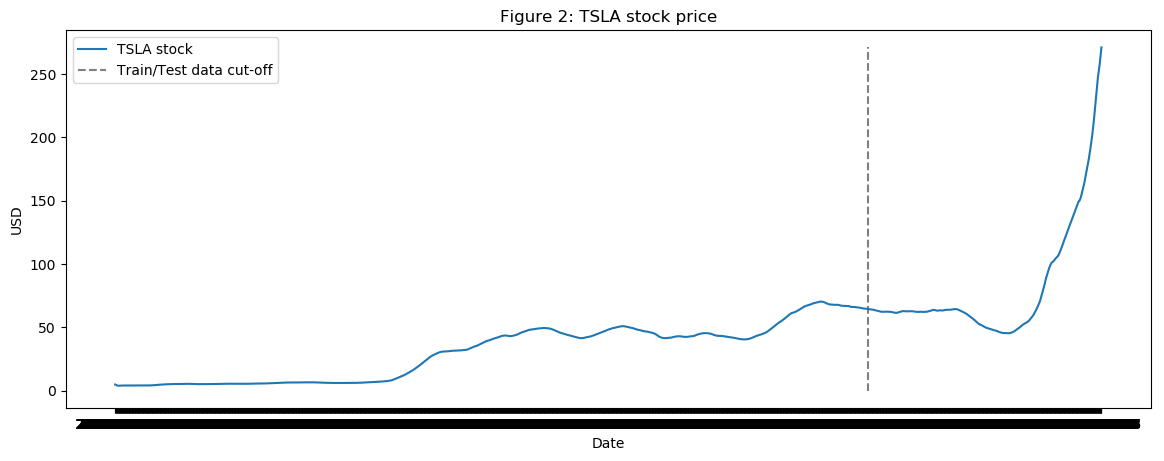

In [306]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['TSLA'], label='{} stock'.format(STOCK))
plt.vlines(datetime.date(2018,4, 20), 0, max(dataset_ex_df[STOCK]), linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: {} stock price'.format(STOCK))
plt.legend()
plt.show()

In [307]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1802. Number of test days: 773.


In [308]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset[STOCK].rolling(window=7).mean()
    dataset['ma21'] = dataset[STOCK].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = pd.DataFrame.ewm(dataset[STOCK], span=26).mean()
    dataset['12ema'] = pd.DataFrame.ewm(dataset[STOCK], span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset[STOCK].rolling(window=20,min_periods=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset[STOCK].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset[STOCK]-1
    
    return dataset

In [309]:
dataset_TI_df = get_technical_indicators(dataset_ex_df)


In [310]:
dataset_TI_df.tail()

,Unnamed: 0,Date,TSLA,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
2570,2570,2020-09-14,259.472799,252.350605,231.610831,227.463645,245.002800,17.539154,17.840838,267.292508,195.929154,258.178593,258.472799
2571,2571,2020-09-15,262.559139,254.791033,234.506814,230.063311,247.703775,17.640463,17.648796,269.804407,199.209222,261.098957,261.559139
2572,2572,2020-09-16,265.526439,257.266285,237.420631,232.690210,250.445723,17.755513,17.440611,272.301853,202.539409,264.050612,264.526439
2573,2573,2020-09-17,268.163239,259.859410,240.330588,235.317842,253.171495,17.853653,17.187612,274.705813,205.955364,266.792363,267.163239
2574,2574,2020-09-18,271.046499,262.556570,243.247923,237.964409,255.921495,17.957087,16.935911,277.119744,209.376101,269.628454,270.046499


In [311]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[STOCK],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

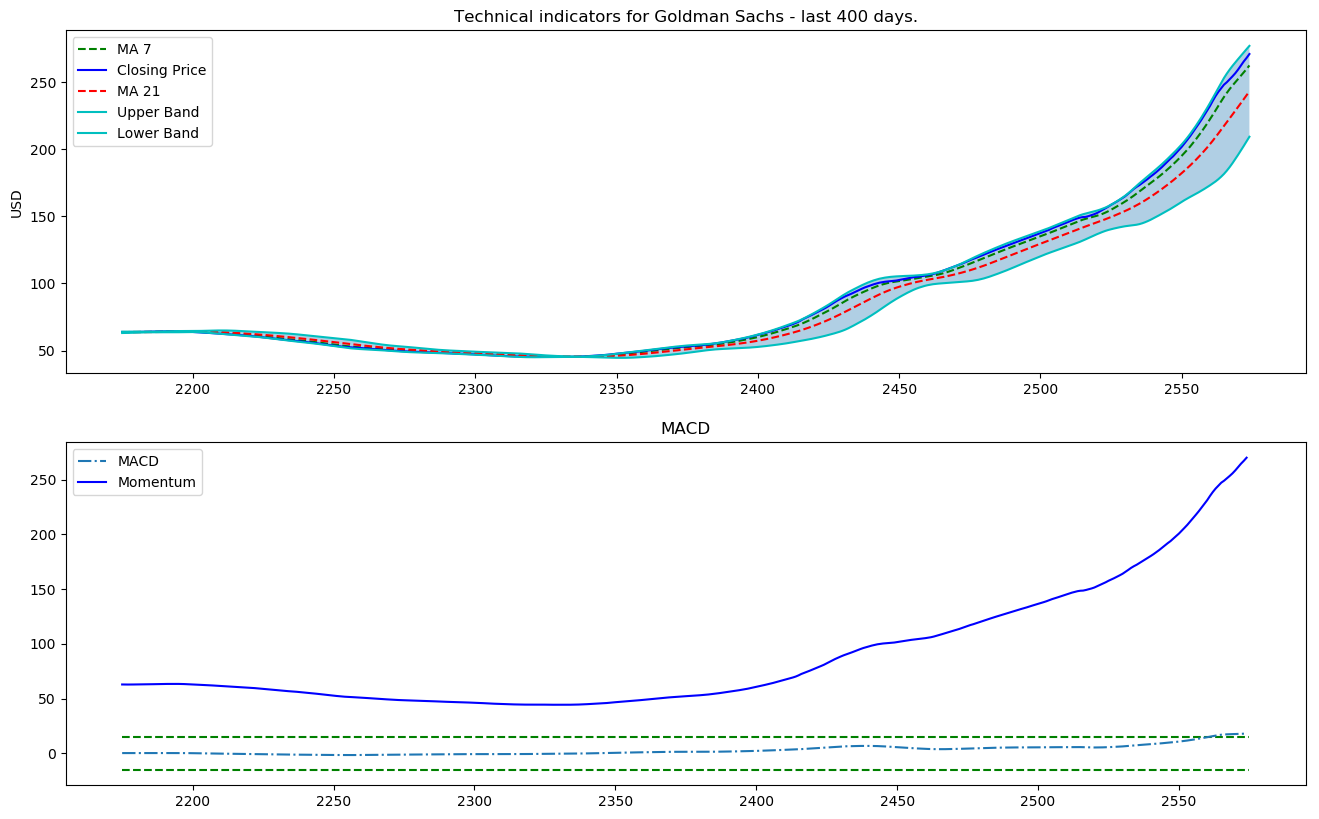

In [312]:
plot_technical_indicators(dataset_TI_df, 400)

In [313]:
data_FT = dataset_ex_df[['Date', STOCK]]

In [314]:
close_fft = np.fft.fft(np.asarray(data_FT[STOCK].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

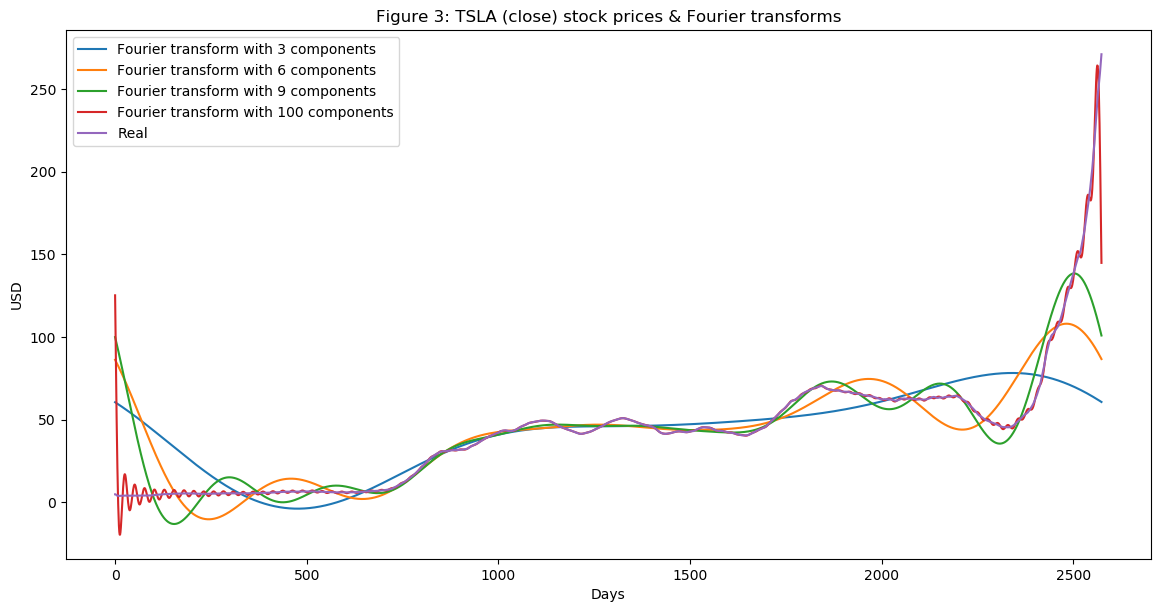

In [315]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT[STOCK],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: {} (close) stock prices & Fourier transforms'.format(STOCK))
plt.legend()
plt.show()

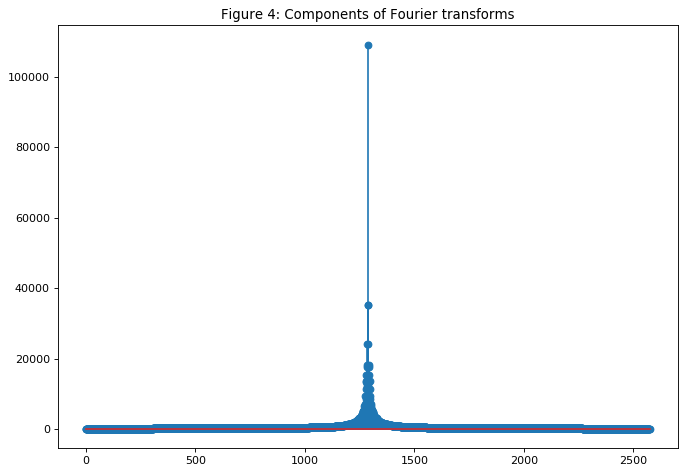

In [316]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [318]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT[STOCK]
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

ImportError: cannot import name 'cached_value'